# Business context

Metaloop is a metal recycling company based in Graz, Austria. We operate as a digital scrap-yard, which means we don't own or lease any warehouses where we store material. Instead, we do the matching of suppliers (also called "sellers") and buyers online, through a managed marketplace.

Our main sources of inbound marketing is a from a form that is available in our website. It's called internally the "Pro-form", and it's the form filled out by enterprise customers to sell a specified quantity of scrap metal. This form can be found on our main page, on the button that says "Request a quote", as shown in the image below:

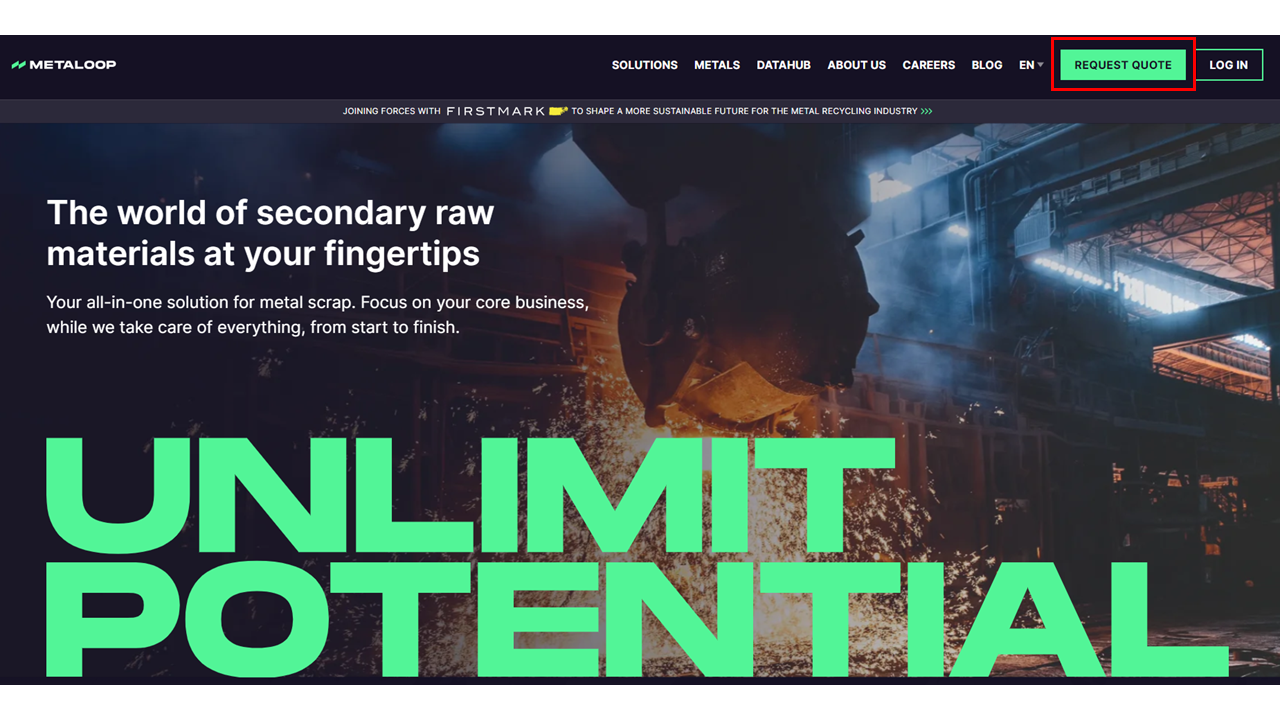

After clicking the button, the prospect is redirected to the form in the next image

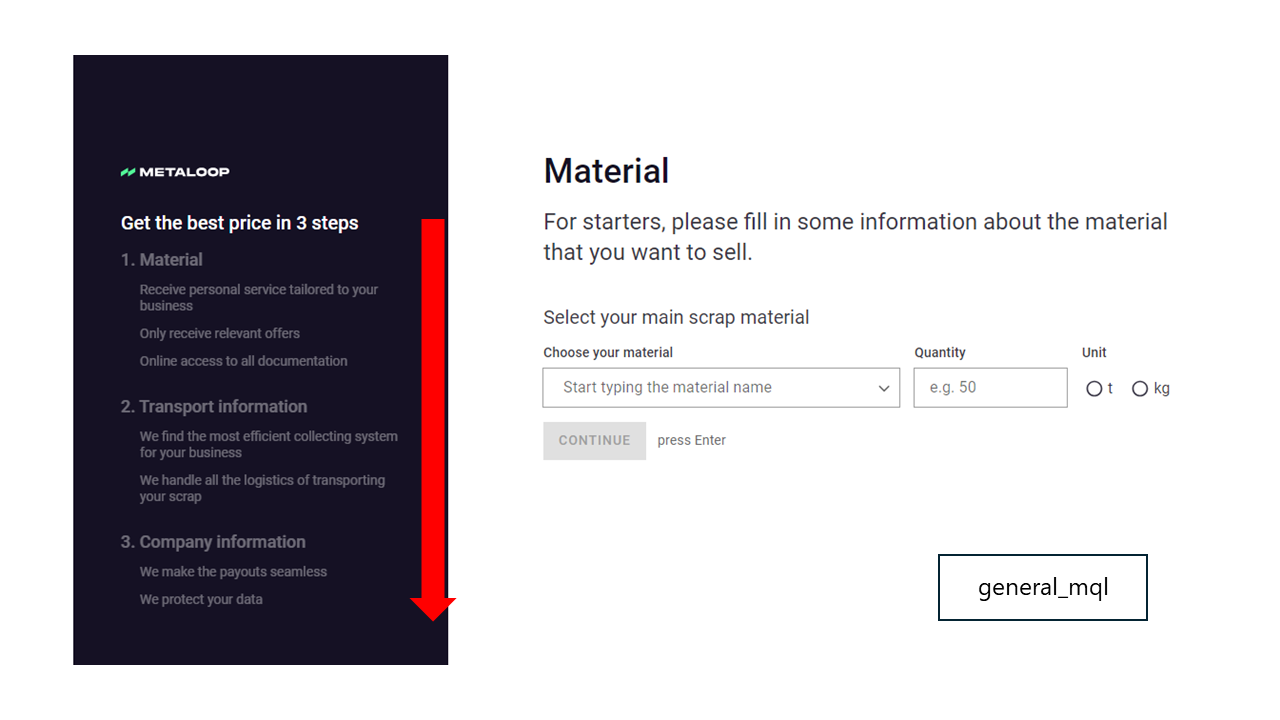

After completing this form, an opportunity record is created on our CRM system and the sales department takes it from there. We do not directly sell anything from the website for wholesale customer, our deals are of high involvement and the sales team always needs to qualify and follow up. Therefore, our most important conversion in the website is the completion of this form.

The completion of this form is tracked in the Google Analytics suite via the tag manager. The event that records the submission of the pro-form is called "general-mql". Due to the fact that no sale occurs on the website, Google analytics can't calculate ROI or LTV out of the box. Another limiting factor to analysis is the long sale cycle. Generally, from a new prospect to a first order delivered, when we realize the revenue, we will take at least 45 days.  

Our goal here is to assess and the effectiveness of our SAE efforts on the webpage, and decide on future steps

## Initial analysis

Before looking into the specific conversion of the campaigns, we will analyse the effectiveness of the inbound channel as a whole. As mentioned above, all of the opportunities created from the pro-form generate an opportunity in our CRM with the flag "from pro form". There are other sources of inbound traffic in our company, mainly in people calling up our sales people directly. However, this is not consistently tracked and represents a small proportion of the volume. Furthermore, for most cases (i.e: existing customers) these are not dependent on the SAE efforts, which is the focus of this study.

Before developing more into the analysis we stablish a connection to our datawarehouse. This is relevant because several transformations are required to get to correct numbers, given that we are looking at the supplier side of the transaction (i.e: sellers) and that implies that GMV and margin must be estimated in several occasions (namely when the material goes into stock first)

In [337]:
# Connect to Databricks
from databricks import sql
import os
from dotenv import load_dotenv
from pyspark.sql import SparkSession
import pandas as pd

# Load the environment variables
load_dotenv()

# Set the connection
connection =  sql.connect(server_hostname = os.getenv("DATABRICKS_SERVER_HOSTNAME"),
                 http_path       = os.getenv("DATABRICKS_HTTP_PATH"),
                 access_token    = os.getenv("PYTHON_ACCESS_TOKEN"))

cursor = connection.cursor()


# Start spark session
spark = SparkSession.builder \
    .appName("mkt_analysis_2024") \
    .getOrCreate()

def get_df_from_databricks(query):
    # Execute the query
    cursor.execute(query)
    # Get the result
    result = cursor.fetchall()
    # Get the column names
    columns = [desc[0] for desc in cursor.description]
    # Create a pandas DataFrame
    df = pd.DataFrame(result, columns=columns)
    return df


In [349]:
# Get all the inbound opportunities
query = """
select 
    pk_opportunity
    , fk_account
    , fk_created_by_user
    , ds_loss_reason
    , flg_is_from_pro_form
    , flg_is_won
    , flg_is_closed
    , ts_created_at
from prd.silver.stg_salesforce__opportunity
where 
-- REMOVING THE FAKE LEADS
(ds_loss_reason != 'fake' or ds_loss_reason is null)
-- KEEP ONLY THE RTS OPP type
and
fk_record_type = '01209000000xizdAAA'
"""

# Get inbound opps
all_opportunities = get_df_from_databricks(query)

# Transform the date columm
all_opportunities['ts_created_at'] = pd.to_datetime(all_opportunities['ts_created_at'])

There are several historical and operational reasons why the values stored in the opportunities object (in terms of estimated GMV and margin) are absiolutely incomplete and not realible. Therefore, we need to use the order objects that are linked to the opportunities in order to get a sense for the revenue and margin generated from these opportunities. It's also worth noting that many of our orders go through an intermediary warehouse before being delivered to the final buyer. When this is the case, we create multiple orders to represent each leg of the journey. Therefore, since we are only interested in the seller (i.e: acquisition) side of the deals, we must keep only the loads that represent the direct transport (called "Mixed") and the ones representing the first leg (i.e: From the seller, called "Acquisition")


In [356]:
# query to create get all orders and make the necessary transformations

query = \
    """
with wholesale_orders as (
    select * from prd.silver.stg_salesforce__order
    where ds_order_status in ('completed', 'buffer')
    and ds_order_record_type != '01209000000xizfAAA'
)

, first_order as (
    select
        fk_seller,
        pk_order,
        dt_checkout_date,
        rank() over(partition by fk_seller order by dt_checkout_date) as order_rank
    from wholesale_orders
    order by fk_seller, order_rank
)


-- GET THE CART ITEM VALUES TO CALCUATE THE STOCK CORRECTIONS
, cart_items as (
    select
        fk_order
        , sum(vl_sale_fifo_out * vl_quantity_purchase) as acquisition_gmv_correction
        , sum(vl_purchase_fifo_out * cast(vl_quantity_sell as numeric(16,2))) as liquidation_nr_correction
        -- FLAG IF THE CORRECTIONS ARE COMPLETE OR NOT
        , sum(case when vl_sale_fifo_out is not null then 1 else 0 end) / count(*) as acquisition_completed_perc
        , sum(case when vl_purchase_fifo_out is not null then 1 else 0 end)/count(*) as liquidation_completed_perc
    from prd.silver.stg_salesforce__cart_item
    where fk_order in (select pk_order from wholesale_orders)
    group by fk_order
)

-- JOIN THE STOCK CORRECTED VALUES INTO THE ORDER
, stock_corrected_order as (
    select 
        *
    from wholesale_orders
    left join cart_items
    on wholesale_orders.pk_order = cart_items.fk_order
)

, sellers as (
    select 
      distinct fk_seller 
      , min(dt_checkout_date) as cohort
    from first_order
    where order_rank = 1
    group by fk_seller
)

, join_seller_cohort as (
    select
        pk_order
        , fk_opportunity
        , fk_trader
        , stock_corrected_order.fk_seller
        , dt_checkout_date
        , cohort
        , ds_type_of_load
        , acquisition_gmv_correction
        , acquisition_completed_perc
        , vl_gmv
        , vl_gross_margin
        , liquidation_nr_correction
        , liquidation_completed_perc
        , vl_total_margin
        , cohort
    from stock_corrected_order
    left join sellers
    on stock_corrected_order.fk_seller = sellers.fk_seller
)

, stock_corrected as (
    select
        pk_order
        , fk_seller
        , fk_opportunity
        , dt_checkout_date
        , cohort
        , ds_type_of_load
        , acquisition_completed_perc
        , liquidation_completed_perc
        , case 
            when ds_type_of_load = "Acquisition"
                then acquisition_gmv_correction
            else
                vl_gmv
        end as adjusted_gmv
        , case 
            when ds_type_of_load = "Acquisition"
                then acquisition_gmv_correction + vl_gross_margin
            when ds_type_of_load = "Liquidation"
                then vl_gross_margin - liquidation_nr_correction
            else
                vl_gross_margin
        end as adjusted_net_revenue
        , case 
            when ds_type_of_load = "Acquisition"
                then acquisition_gmv_correction + vl_total_margin
            when ds_type_of_load = "Liquidation"
                then vl_total_margin - liquidation_nr_correction
            else
                vl_total_margin
        end as adjusted_contribution_margin
    from join_seller_cohort
)

, final (
    select 
        *
    from stock_corrected
    where 
        (ds_type_of_load = 'Acquisition' and acquisition_completed_perc = 1)
        or ds_type_of_load = 'Mixed'
)

select * from final
order by adjusted_contribution_margin

"""

# Create df with all orders from the seller side
all_orders = get_df_from_databricks(query)

all_orders['dt_checkout_date'] = pd.to_datetime(all_orders['dt_checkout_date'], format='%Y-%m-%d')
all_orders['cohort'] = pd.to_datetime(all_orders['cohort'], format='%Y-%m-%d')
all_orders['from_opp'] = ~all_orders['fk_opportunity'].isna()

# Transform number columns to numeric
all_orders['adjusted_gmv'] = pd.to_numeric(all_orders['adjusted_gmv'])
all_orders['adjusted_net_revenue'] = pd.to_numeric(all_orders['adjusted_net_revenue'])
all_orders['adjusted_contribution_margin'] = pd.to_numeric(all_orders['adjusted_contribution_margin'])

# Drop helper columns
all_orders.drop(columns=['acquisition_completed_perc', 'liquidation_completed_perc'], inplace=True)

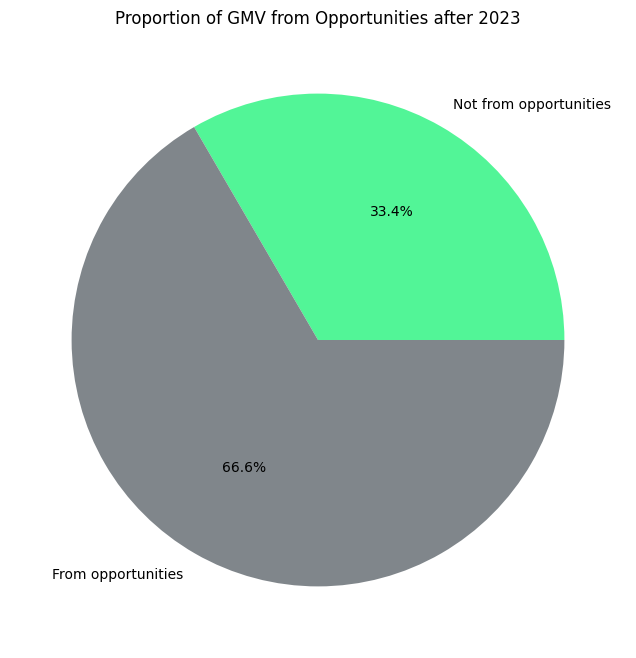

In [351]:
import matplotlib.pyplot as plt

# Defining color palette

color_palette = {
    'green1': '#52F597',
    'grey1': '#80868B',
    'red': '#D90A0A'
}

# Plot proportion of gmv from opportunities from the total
gmv_from_opportunities = all_orders[all_orders['dt_checkout_date'] >= '2023-01-01'].groupby('from_opp')['adjusted_gmv'].sum()
plt.figure(figsize=(8, 8))

plt.pie(gmv_from_opportunities, labels=['Not from opportunities', 'From opportunities'], autopct='%1.1f%%', colors=[color_palette['green1'],color_palette['grey1']])
plt.title('Proportion of GMV from Opportunities after 2023')
plt.show()


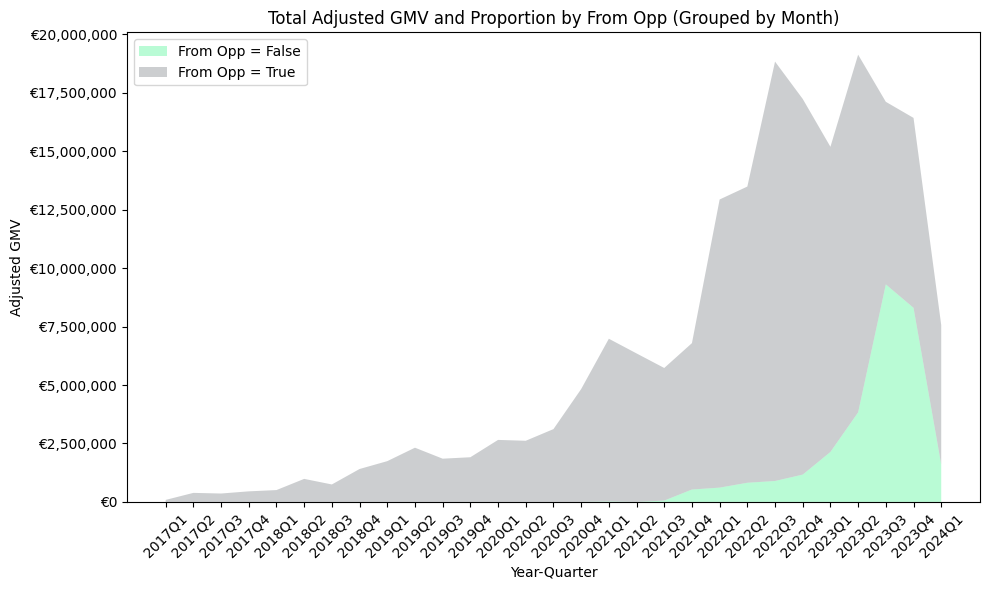

In [352]:
# Group by month and sum the adjusted_gmv for each month
total_gmv = all_orders.groupby(all_orders['dt_checkout_date'].dt.to_period('Q'))['adjusted_gmv'].sum()

# Group by month, checkout_date, and from_opp, then calculate the sum of adjusted_gmv for each group
grouped_gmv = all_orders.groupby([all_orders['dt_checkout_date'].dt.to_period('Q'), 'from_opp'])['adjusted_gmv'].sum().unstack(fill_value=0)

# Calculate the proportion of adjusted_gmv for from_opp = True and False
proportion_from_opp_true = grouped_gmv[True] / total_gmv
proportion_from_opp_false = grouped_gmv[False] / total_gmv

# Plotting
plt.figure(figsize=(10, 6))

# Plot stacked area chart
plt.stackplot(total_gmv.index.astype(str),
              [grouped_gmv[False], grouped_gmv[True]],
              labels=['From Opp = False', 'From Opp = True'],
              colors=[color_palette['green1'],color_palette['grey1']], alpha=0.4)

# Y axis in euros
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'€{x:,.0f}'))

# Customize plot
plt.xlabel('Year-Quarter')
plt.ylabel('Adjusted GMV')
plt.title('Total Adjusted GMV and Proportion by From Opp (Grouped by Month)')
plt.legend(loc='upper left')
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()

Now we add the context of whether or not the opportunity that originated that order came from the pro form. The results are shown bellow. It's clear that in terms of margin contribution, the pro form orders do not play a significant role directly.

/var/folders/9q/j7lbhmyn7rn9k4c3p7kgjhwh0000gn/T/ipykernel_6839/556741207.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=all_orders, x='flg_is_from_pro_form', y='adjusted_gmv',


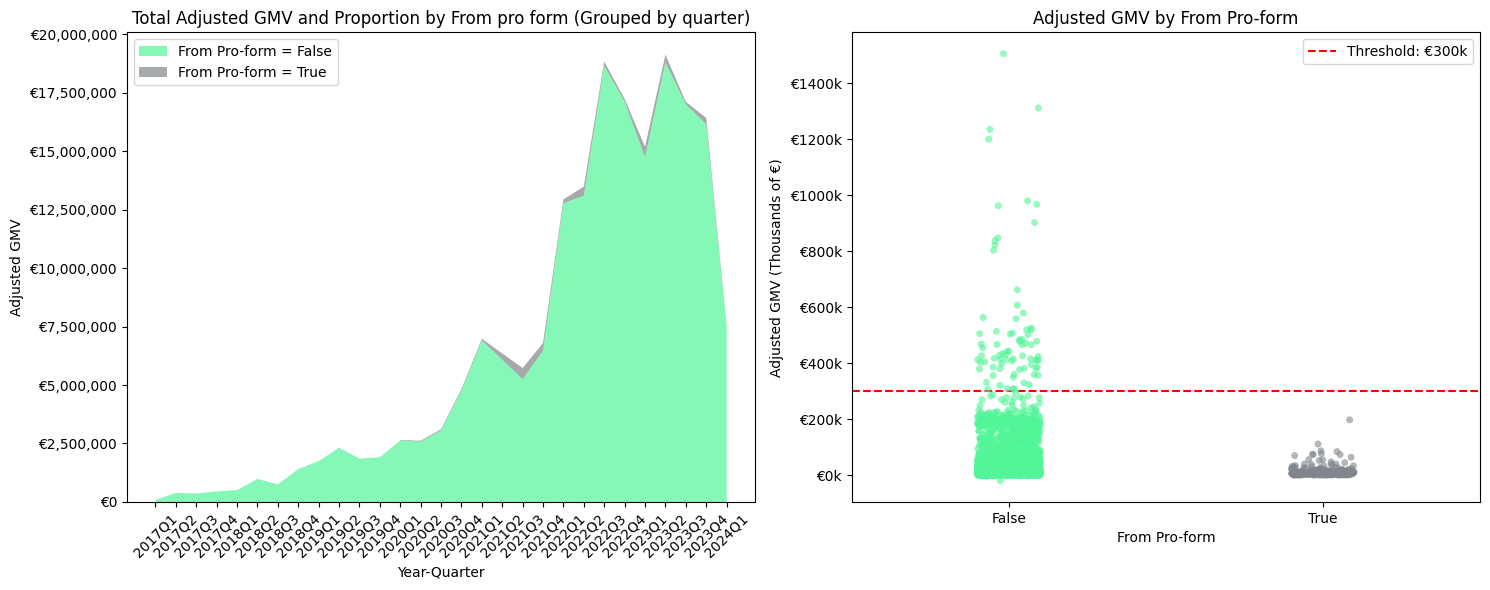

In [362]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker

# Plotting
plt.figure(figsize=(15, 6))

# First subplot: Stacked area chart
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.stackplot(total_gmv.index.astype(str),
              [grouped_gmv[False], grouped_gmv[True]],
              labels=['From Pro-form = False', 'From Pro-form = True'],
              colors=[color_palette['green1'],color_palette['grey1']], alpha=0.7)

# Y axis in euros
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'€{x:,.0f}'))

# Customize plot
plt.xlabel('Year-Quarter')
plt.ylabel('Adjusted GMV')
plt.title('Total Adjusted GMV and Proportion by From pro form (Grouped by quarter)')
plt.legend(loc='upper left')
plt.xticks(rotation=45)

# Second subplot: Strip plot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
sns.stripplot(data=all_orders, x='flg_is_from_pro_form', y='adjusted_gmv', 
              palette=[color_palette['green1'],color_palette['grey1']], jitter=True, alpha=0.6)

# Customize plot
plt.xlabel('From Pro-form')
plt.ylabel('Adjusted GMV (Thousands of €)')
plt.title('Adjusted GMV by From Pro-form')

# Format y-axis ticks as millions of euros with euro sign
formatter = ticker.FuncFormatter(lambda x, pos: f'€{x / 1000:.0f}k')
plt.gca().yaxis.set_major_formatter(formatter)

# Plot horizontal line at 300,000 euros
plt.axhline(y=300000, color='red', linestyle='--', label='Threshold: €300k')

# Show plot
plt.legend()
plt.tight_layout()
plt.show()


We know that this is a somewhat limiting approach (only looking at the opportunity level), since accounts could have started from the pro-form, but developed into a recurring customer. Before we dig deeper into the definition of inbound, we explore the customer retention of the base:

## Customer retention

The customer retention is calculated based on the adjusted contribution margin. The margin needs to be adjusted to accomodate the Acquisition orders (i.e: orders that go into stock) from the Seller's perspective. Some orders with negative margin are expected (due to actual losses or bundled orders). They should even out across time.

Then we define the "cohort month", which is the date-month of the sellers first order. Here we are grouping by order creation date (since we are looking at marketing efforts). Note that this date can be very different from the order date or delivery date, specially for larger orders.

The "cohort number" represents the month relative to the acquisiton of the order. For example, an order with cohort month = 1 represents an order that occured in the next calendar month from acquisition (i.e: zero indexed)

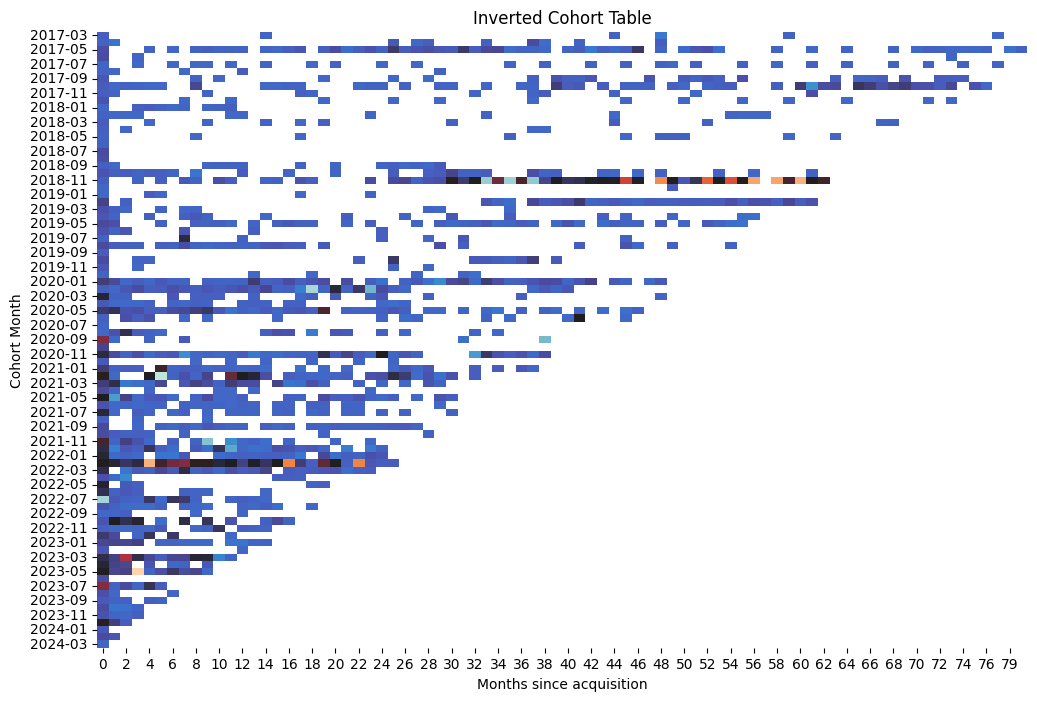

In [177]:
all_orders['cohort_number'] = (all_orders['dt_checkout_date'].dt.year - all_orders['cohort'].dt.year) * 12 \
                                 + (all_orders['dt_checkout_date'].dt.month - all_orders['cohort'].dt.month)


all_orders['cohort_month'] = all_orders['cohort'].dt.to_period('M')
# Plot inverted cohort table with color coding

# Create the pivot table
cohort_table = all_orders.pivot_table(index='cohort_month', columns='cohort_number', values='adjusted_contribution_margin', aggfunc='sum')

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cohort_table, cmap='icefire', annot=False, fmt='.0f', cbar=False)

plt.title('Inverted Cohort Table')
plt.ylabel('Cohort Month')
plt.xlabel('Months since acquisition')

plt.show()

For better clarity, we repeat the analysis grouping by year-quarter:

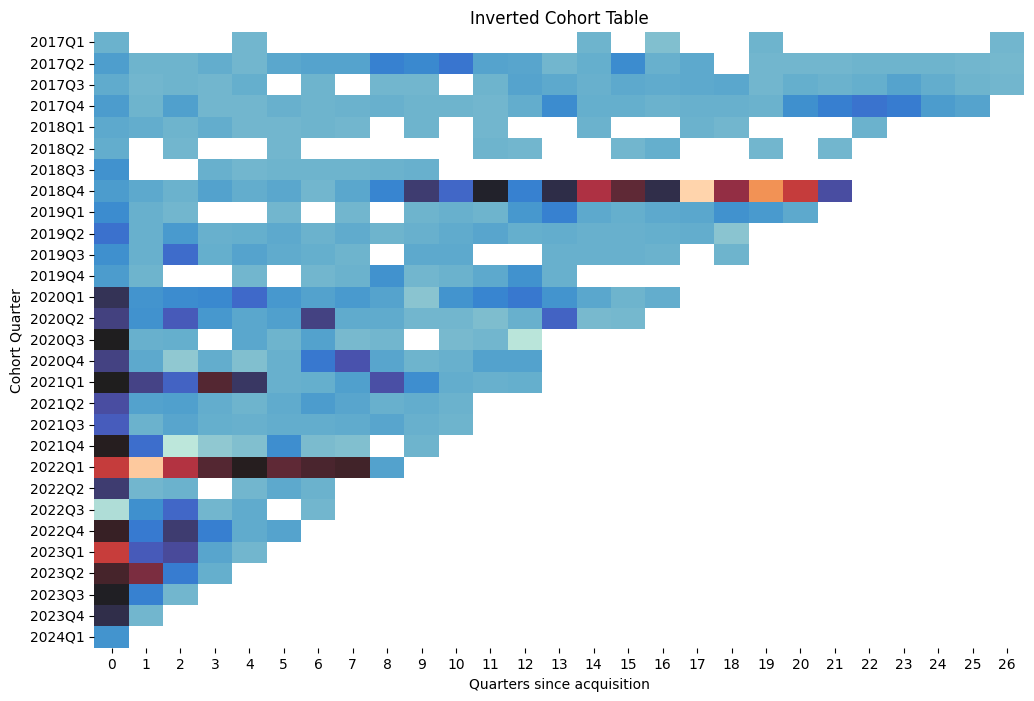

In [393]:
# Plot overall cohort retention rate as a line plot

all_orders['cohort_number_q'] = ((all_orders['dt_checkout_date'] - all_orders['cohort']).dt.days / 91).astype(int)


all_orders['cohort_quarter'] = all_orders['cohort'].dt.to_period('Q')
# Plot inverted cohort table with color coding

# Create the pivot table
cohort_table = all_orders.pivot_table(index='cohort_quarter', columns='cohort_number_q', values='adjusted_contribution_margin', aggfunc='sum')

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cohort_table, cmap='icefire', annot=False, fmt='.0f', cbar=False)

plt.title('Inverted Cohort Table')
plt.ylabel('Cohort Quarter')
plt.xlabel('Quarters since acquisition')

plt.show()

Some obvious trends are that the newer cohorts (i.e: down accross the y axis) have a higher value and better retention, although retention is visible throughout the entire base. The notable exception in cohort 2018Q4 reffers to Wiener Netze, our most profitable account. In order to check if we have an overall retention across cohorts YoY, we plot a cohort retention line plot (exluding this year). We see that in general we retain a lot of our revenue in time, with 25% being our lowest retention rate from the initial cohort (we used a log scale for better visualization, given the demolation project started in 2018 that generates a huge outlier in retention)

/var/folders/9q/j7lbhmyn7rn9k4c3p7kgjhwh0000gn/T/ipykernel_6839/3816135218.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cohort_number_y'] = (data['dt_checkout_date'].dt.year - data['cohort'].dt.year).astype(int)
/var/folders/9q/j7lbhmyn7rn9k4c3p7kgjhwh0000gn/T/ipykernel_6839/3816135218.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cohort_year'] = data['cohort'].dt.to_period('Y')


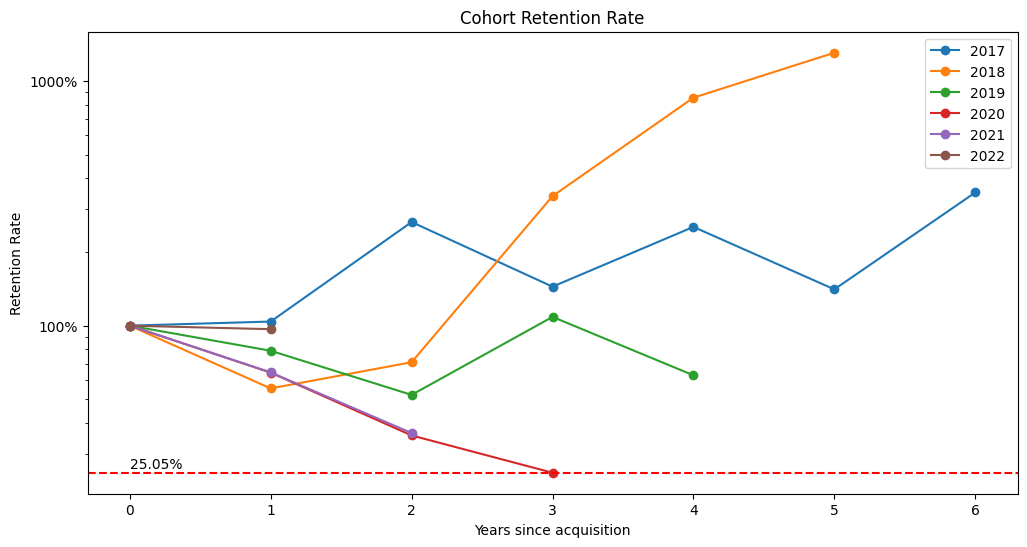

In [368]:
data = all_orders[all_orders['dt_checkout_date'] < '2024-01-01']
# Create line plot from the cohort table by year
data['cohort_number_y'] = (data['dt_checkout_date'].dt.year - data['cohort'].dt.year).astype(int)
data['cohort_year'] = data['cohort'].dt.to_period('Y')

cohort_table = data.pivot_table(index='cohort_year', columns='cohort_number_y', values='adjusted_contribution_margin', aggfunc='sum')

# Calculate the retention rate for each cohort from the first cohort
retention_rate = cohort_table.divide(cohort_table.iloc[:, 0], axis=0)

# Filter out irrelevant years
retention_rate = retention_rate.loc[retention_rate.index.year < 2023]

# Plot the retention rate
plt.figure(figsize=(12, 6))
plt.plot(retention_rate.T, marker='o')

# Add a horizontal line and annotate on the lowest retention rate
lowest_retention_rate = retention_rate.min().min()
plt.axhline(lowest_retention_rate, color='red', linestyle='--', label=f'Lowest retention rate: {lowest_retention_rate:.2%}')
plt.annotate(f'{lowest_retention_rate:.2%}', xy=(0, lowest_retention_rate+.01), xytext=(0, lowest_retention_rate + 0.2), textcoords='offset points', color='black')



# Plot y in log scale
plt.yscale('log')
plt.title('Cohort Retention Rate')
plt.xlabel('Years since acquisition')
plt.ylabel('Retention Rate')
plt.xticks(range(0, 7))
plt.legend(retention_rate.index)

# y ticks in percentage
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))

plt.show()


Let's take a look at the cohort behavior for pro form sellers exclusively:

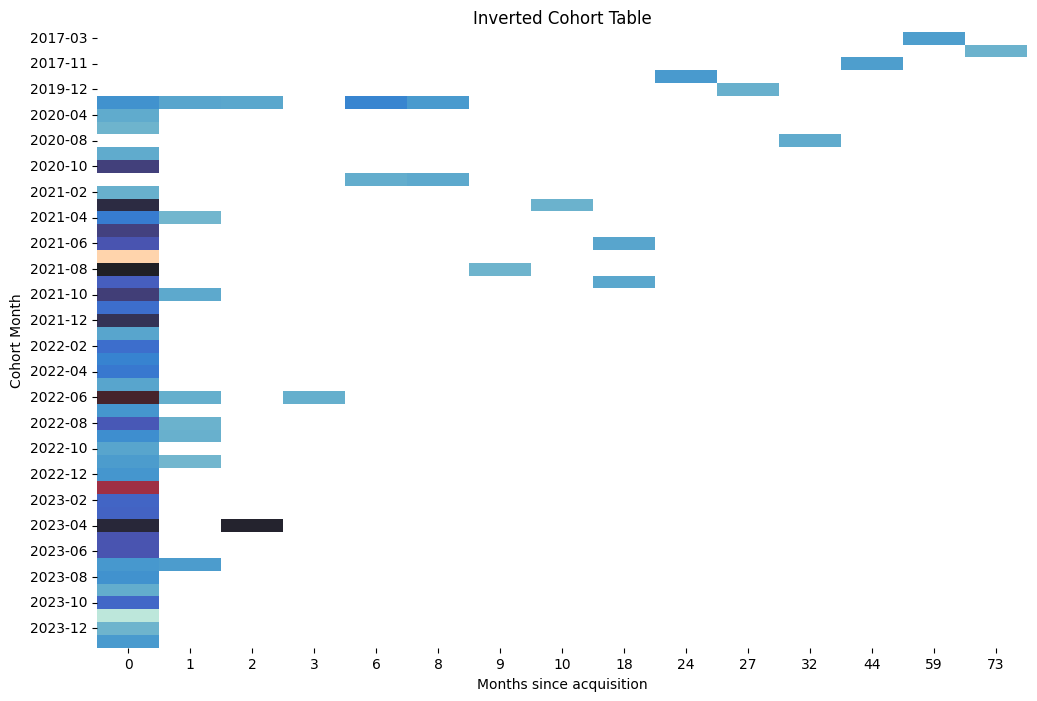

In [364]:
# Filter for pro form orders exclusively
data = all_orders[all_orders['flg_is_from_pro_form']].copy()


data['cohort_number'] = (data['dt_checkout_date'].dt.year - data['cohort'].dt.year) * 12 \
                                 + (data['dt_checkout_date'].dt.month - data['cohort'].dt.month)


data['cohort_month'] = data['cohort'].dt.to_period('M')
# Plot inverted cohort table with color coding

# Create the pivot table
cohort_table = data.pivot_table(index='cohort_month', columns='cohort_number', values='adjusted_contribution_margin', aggfunc='sum')

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cohort_table, cmap='icefire', annot=False, fmt='.0f', cbar=False)

plt.title('Inverted Cohort Table')
plt.ylabel('Cohort Month')
plt.xlabel('Months since acquisition')

plt.show()

Although we see a clear retention profile for our general base, the retention for pro-form exclusevily sellers is much more limited. Therefore, CLV via different methods:

**CLV with fixed horizon**
The CLV with fixed horizon aims at estimating the _present_ lifetime value of the new account. For marketing, putting it in terms of present value is relevant because all of the investment in campaigns is made upfront. The formula is:

$$
CLV = \sum_{t=1}^N\frac{r_tM_t}{(1+i)^{t-1}} - AC
$$

Where $M_t$ is the expected margin at period t (in our case, this is constant), $r_t$ is the recurrance rate at period t, i is the discount rate (i.e: the discount rate per period of future value in comparison to present value) and N is the horizon (AC is the acquisition cost. We will not focus on this at first).

We can also use a geometric approximation to arrive at an **infinite-horizon formulation**.

$$
CLV = \frac{M}{1-r+i} - AC
$$

We start by calculating the possible values of CLV for orders generated from pro-form opportunities

In [374]:
# Now calculate the CLV for our customers in different methods

# Set all the orders from with the pro form flag
data = all_orders[all_orders['flg_is_from_pro_form']].copy()  # Make a copy to avoid SettingWithCopyWarning
data['cohort_number'] = (data['dt_checkout_date'].dt.year - data['cohort'].dt.year) * 12 \
                                 + (data['dt_checkout_date'].dt.month - data['cohort'].dt.month)
data['cohort_month'] = data['cohort'].dt.to_period('M')

inbound_total_margin = data[data['cohort_number'] == 0]['adjusted_contribution_margin'].sum()
#inbound_total_margin = data['adjusted_contribution_margin'].sum()
inbound_total_sellers = data['fk_seller'].nunique()
expected = inbound_total_margin / inbound_total_sellers

# Calculating the infinte horizon CLV
discount_rate = 0.1

# Calculate the retention rate for each cohort from the first cohort
retention_rate = 0.05

# Infinite horizon CLV formula
infinite_clv = expected*(1+discount_rate)/(1+discount_rate-retention_rate)

# Fixed horizon CLV
# Relevant retention rates only consider the margin from the cohort 0 that would be possible for the cohort in question
retention_rates_relevant = []

# Absolute retention rates considers all cohorts in the calculation
retention_rates_absolute = []

for cohort in range(1, data['cohort_number'].max()+1):
    relevant_zero_cohort_margin = data[(data['cohort_number'] == 0) & \
                                (data['cohort_month']<= data['cohort_month'].max()-cohort)]\
                                    ['adjusted_contribution_margin'].sum()
    relevant_cohort_margin = data[data['cohort_number'] == cohort]['adjusted_contribution_margin'].sum()
    absolute_zero_cohort_margin = data[data['cohort_number'] == 0]\
                                    ['adjusted_contribution_margin'].sum()
    retention_rates_relevant.append(relevant_cohort_margin/relevant_zero_cohort_margin)
    retention_rates_absolute.append(relevant_cohort_margin/absolute_zero_cohort_margin)

horizon = 3
absolute_clv = 0
relevant_clv = 0

for i in range(horizon):
    absolute_clv += expected*((retention_rates_absolute[i]/(1+discount_rate))**i)
    relevant_clv += expected*((retention_rates_relevant[i]/(1+discount_rate))**i)

print(f'Total margin from inbound orders: €{inbound_total_margin:,.0f}')
print(f'Total number of sellers from inbound orders: {inbound_total_sellers}')
print(f'Average LTV per seller from inbound orders: €{expected:,.0f}')
print(f'Infinite horizon CLV: €{infinite_clv:,.0f}')
print(f'Fixed horizon CLV (absolute): €{absolute_clv:,.0f}')
print(f'Fixed horizon CLV (relevant): €{relevant_clv:,.0f}')

Total margin from inbound orders: €173,169
Total number of sellers from inbound orders: 218
Average LTV per seller from inbound orders: €794
Infinite horizon CLV: €832
Fixed horizon CLV (absolute): €836
Fixed horizon CLV (relevant): €836


/var/folders/9q/j7lbhmyn7rn9k4c3p7kgjhwh0000gn/T/ipykernel_6839/3727266724.py:37: RuntimeWarning: invalid value encountered in scalar divide
  retention_rates_relevant.append(relevant_cohort_margin/relevant_zero_cohort_margin)
/var/folders/9q/j7lbhmyn7rn9k4c3p7kgjhwh0000gn/T/ipykernel_6839/3727266724.py:37: RuntimeWarning: invalid value encountered in scalar divide
  retention_rates_relevant.append(relevant_cohort_margin/relevant_zero_cohort_margin)
/var/folders/9q/j7lbhmyn7rn9k4c3p7kgjhwh0000gn/T/ipykernel_6839/3727266724.py:37: RuntimeWarning: invalid value encountered in scalar divide
  retention_rates_relevant.append(relevant_cohort_margin/relevant_zero_cohort_margin)
/var/folders/9q/j7lbhmyn7rn9k4c3p7kgjhwh0000gn/T/ipykernel_6839/3727266724.py:37: RuntimeWarning: invalid value encountered in scalar divide
  retention_rates_relevant.append(relevant_cohort_margin/relevant_zero_cohort_margin)
/var/folders/9q/j7lbhmyn7rn9k4c3p7kgjhwh0000gn/T/ipykernel_6839/3727266724.py:37: RuntimeWar

Next, we look at all opportunities where the seller was a part of a pro-form opportunity. This is a broader definition, assuming that sellers who ever iteracted with the pro-form reached us via the inbound method, even if the first opp was not won.

In [375]:
# Now calculate the CLV for our customers in different methods

# Inbound exclusively customers
inbound_sellers = all_opportunities[all_opportunities['flg_is_from_pro_form']]['fk_account'].unique()

# Set all the orders from inbound sellers
data = all_orders[all_orders['fk_seller'].isin(inbound_sellers)].copy()  # Make a copy to avoid SettingWithCopyWarning
data['cohort_number'] = (data['dt_checkout_date'].dt.year - data['cohort'].dt.year) * 12 \
                                 + (data['dt_checkout_date'].dt.month - data['cohort'].dt.month)
data['cohort_month'] = data['cohort'].dt.to_period('M')

inbound_total_margin = data[data['cohort_number'] == 0]['adjusted_contribution_margin'].sum()
#inbound_total_margin = data['adjusted_contribution_margin'].sum()
inbound_total_sellers = data['fk_seller'].nunique()
expected = inbound_total_margin / inbound_total_sellers

# Calculating the infinte horizon CLV
discount_rate = 0.1

# Calculate the retention rate for each cohort from the first cohort
retention_rate = 0.05

# Infinite horizon CLV formula
infinite_clv = expected*(1+discount_rate)/(1+discount_rate-retention_rate)

# Fixed horizon CLV
# Relevant retention rates only consider the margin from the cohort 0 that would be possible for the cohort in question
retention_rates_relevant = []

# Absolute retention rates considers all cohorts in the calculation
retention_rates_absolute = []

for cohort in range(1, data['cohort_number'].max()+1):
    relevant_zero_cohort_margin = data[(data['cohort_number'] == 0) & \
                                (data['cohort_month']<= data['cohort_month'].max()-cohort)]\
                                    ['adjusted_contribution_margin'].sum()
    relevant_cohort_margin = data[data['cohort_number'] == cohort]['adjusted_contribution_margin'].sum()
    absolute_zero_cohort_margin = data[data['cohort_number'] == 0]\
                                    ['adjusted_contribution_margin'].sum()
    retention_rates_relevant.append(relevant_cohort_margin/relevant_zero_cohort_margin)
    retention_rates_absolute.append(relevant_cohort_margin/absolute_zero_cohort_margin)

horizon = 12
absolute_clv = 0
relevant_clv = 0

for i in range(horizon):
    absolute_clv += expected*((retention_rates_absolute[i]/(1+discount_rate))**i)
    relevant_clv += expected*((retention_rates_relevant[i]/(1+discount_rate))**i)

print(f'Total margin from inbound orders: €{inbound_total_margin:,.0f}')
print(f'Total number of sellers from inbound orders: {inbound_total_sellers}')
print(f'Average LTV per seller from inbound orders: €{expected:,.0f}')
print(f'Infinite horizon CLV: €{infinite_clv:,.0f}')
print(f'Fixed horizon CLV (absolute): €{absolute_clv:,.0f}')
print(f'Fixed horizon CLV (relevant): €{relevant_clv:,.0f}')

Total margin from inbound orders: €243,864
Total number of sellers from inbound orders: 280
Average LTV per seller from inbound orders: €871
Infinite horizon CLV: €912
Fixed horizon CLV (absolute): €1,015
Fixed horizon CLV (relevant): €1,021


We can expand this definition further, in assuming all opportunities that are created from the account managers that deal exclusively with inbound can also be classified as an inbound account. The results of this approach are shown below

In [376]:
# Now calculate the CLV for our customers in different methods

# Inbound exclusively customers
inbound_account_managers = ['0050900000Adq5kAAB',
                            '00509000003YyzxAAC']

# Inbound exclusively customers, assuming all opportunities from inbound account managers are inbound
inbound_sellers = all_opportunities[(all_opportunities['flg_is_from_pro_form']) | (all_opportunities['fk_created_by_user'].isin(inbound_account_managers))]['fk_account'].unique()

# Drop the None seller
inbound_sellers = inbound_sellers[~pd.isna(inbound_sellers)]

# Set all the orders from inbound sellers
data = all_orders[all_orders['fk_seller'].isin(inbound_sellers)].copy()  # Make a copy to avoid SettingWithCopyWarning
data['cohort_number'] = (data['dt_checkout_date'].dt.year - data['cohort'].dt.year) * 12 \
                                 + (data['dt_checkout_date'].dt.month - data['cohort'].dt.month)
data['cohort_month'] = data['cohort'].dt.to_period('M')

inbound_total_margin = data[data['cohort_number'] == 0]['adjusted_contribution_margin'].sum()
#inbound_total_margin = data['adjusted_contribution_margin'].sum()
inbound_total_sellers = data['fk_seller'].nunique()
expected = inbound_total_margin / inbound_total_sellers

# Calculating the infinte horizon CLV
discount_rate = 0.1

# Calculate the retention rate for each cohort from the first cohort
retention_rate = 0.05

# Infinite horizon CLV formula
infinite_clv = expected*(1+discount_rate)/(1+discount_rate-retention_rate)

# Fixed horizon CLV
# Relevant retention rates only consider the margin from the cohort 0 that would be possible for the cohort in question
retention_rates_relevant = []

# Absolute retention rates considers all cohorts in the calculation
retention_rates_absolute = []

for cohort in range(1, data['cohort_number'].max()+1):
    relevant_zero_cohort_margin = data[(data['cohort_number'] == 0) & \
                                (data['cohort_month']<= data['cohort_month'].max()-cohort)]\
                                    ['adjusted_contribution_margin'].sum()
    relevant_cohort_margin = data[data['cohort_number'] == cohort]['adjusted_contribution_margin'].sum()
    absolute_zero_cohort_margin = data[data['cohort_number'] == 0]\
                                    ['adjusted_contribution_margin'].sum()
    retention_rates_relevant.append(relevant_cohort_margin/relevant_zero_cohort_margin)
    retention_rates_absolute.append(relevant_cohort_margin/absolute_zero_cohort_margin)

horizon = 12
absolute_clv = 0
relevant_clv = 0

for i in range(horizon):
    absolute_clv += expected*((retention_rates_absolute[i]/(1+discount_rate))**i)
    relevant_clv += expected*((retention_rates_relevant[i]/(1+discount_rate))**i)

print(f'Total margin from inbound orders: €{inbound_total_margin:,.0f}')
print(f'Total number of sellers from inbound orders: {inbound_total_sellers}')
print(f'Average LTV per seller from inbound orders: €{expected:,.0f}')
print(f'Infinite horizon CLV: €{infinite_clv:,.0f}')
print(f'Fixed horizon CLV (absolute): €{absolute_clv:,.0f} (horizon: {horizon})')
print(f'Fixed horizon CLV (relevant): €{relevant_clv:,.0f} (horizon: {horizon})')

Total margin from inbound orders: €278,445
Total number of sellers from inbound orders: 340
Average LTV per seller from inbound orders: €819
Infinite horizon CLV: €858
Fixed horizon CLV (absolute): €973 (horizon: 12)
Fixed horizon CLV (relevant): €979 (horizon: 12)


These numbers will be used to estimate the ROI of our campaigns and our target CPC later. However, one of our goals is to assess the performance of our campaigns . The easiest way to do this would be to direclty link each lead to its session (although other considerations need to be made). However, we do not have this due to implementation specificities.

What we will try to do is to match each conversion to the opportunity created shortly after it. There is usually a very small delay in this sync, but sometimes the delay is long (and sometimes it even doesn't happen at all until we catch the bug that blocked it). These cases will not be ignored. The code below attempts to make the match on the timestamp with no tolerance.

In [377]:
# Read the general_mql_events data
general_mql_events = pd.read_csv('data/general_mql_events.csv')

# Transform date columns
general_mql_events['dateHourMinute'] = pd.to_datetime(general_mql_events['dateHourMinute'], format='%Y%m%d%H%M')

# Localize the dateHourMinute column to the 'CET' timezone
general_mql_events['dateHourMinute'] = general_mql_events['dateHourMinute'].dt.tz_localize('CET')

# Convert the dateHourMinute column to its UTC equivalent
general_mql_events['dateHourMinute'] = general_mql_events['dateHourMinute'].dt.tz_convert('UTC')

# Define events from search campaings
general_mql_from_campaign = general_mql_events[general_mql_events['campaignId'] != '(not set)']

# Define inbound opportunities as the opportunties that are from pro-form
inbound_opps = all_opportunities[all_opportunities['flg_is_from_pro_form']][['pk_opportunity', 'ts_created_at', 'fk_account']].copy()

# Time columns to perform minute based match for opportunities
inbound_opps['date'] = pd.to_datetime(inbound_opps['ts_created_at'], format='%Y-%m-%d %H:%M:%S').dt.date
inbound_opps['hour'] = pd.to_datetime(inbound_opps['ts_created_at'], format='%Y-%m-%d %H:%M:%S').dt.hour
inbound_opps['minute'] = pd.to_datetime(inbound_opps['ts_created_at'], format='%Y-%m-%d %H:%M:%S').dt.minute

# Time columns to perform minuite based match for events
general_mql_from_campaign['date'] = general_mql_from_campaign['dateHourMinute'].dt.date
general_mql_from_campaign['hour'] = general_mql_from_campaign['dateHourMinute'].dt.hour
general_mql_from_campaign['minute'] = general_mql_from_campaign['dateHourMinute'].dt.minute

#Match the two dataframes on date, hour and minute
exact_minute_match = pd.merge(general_mql_from_campaign, inbound_opps, how='inner', on=['date', 'hour', 'minute'])

print(f"Number of matches in the exact minute: {exact_minute_match.shape[0]}")

Number of matches in the exact minute: 77


/var/folders/9q/j7lbhmyn7rn9k4c3p7kgjhwh0000gn/T/ipykernel_6839/2511210094.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  general_mql_from_campaign['date'] = general_mql_from_campaign['dateHourMinute'].dt.date
/var/folders/9q/j7lbhmyn7rn9k4c3p7kgjhwh0000gn/T/ipykernel_6839/2511210094.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  general_mql_from_campaign['hour'] = general_mql_from_campaign['dateHourMinute'].dt.hour
/var/folders/9q/j7lbhmyn7rn9k4c3p7kgjhwh0000gn/T/ipykernel_6839/2511210094.py:27

With an exact match on the minute, we only get 77 matches. We recalculate this match within a range of tolerance candidates

/var/folders/9q/j7lbhmyn7rn9k4c3p7kgjhwh0000gn/T/ipykernel_6839/1321420654.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  general_mql_from_campaign['datetime'] = pd.to_datetime(general_mql_from_campaign['dateHourMinute'], format='%Y-%m-%d %H:%M:%S')
/var/folders/9q/j7lbhmyn7rn9k4c3p7kgjhwh0000gn/T/ipykernel_6839/1321420654.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  general_mql_from_campaign['datetime'] = general_mql_from_campaign['datetime'].dt.tz_localize(None)


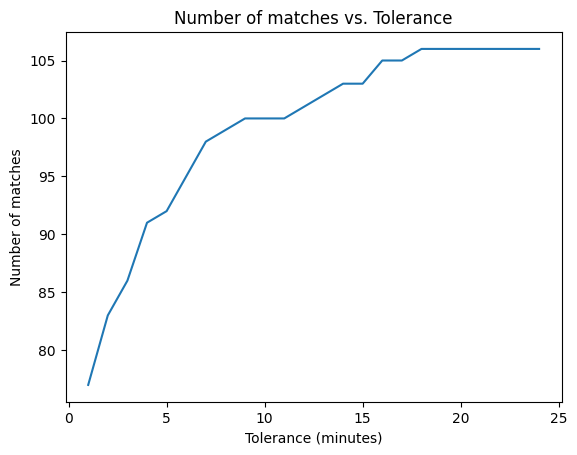

In [378]:
# Create datetime column to perform the match with tolerance
inbound_opps['datetime'] = pd.to_datetime(inbound_opps['ts_created_at'], format='%Y-%m-%d %H:%M:%S')
general_mql_from_campaign['datetime'] = pd.to_datetime(general_mql_from_campaign['dateHourMinute'], format='%Y-%m-%d %H:%M:%S')

# Remove the time zone information
inbound_opps['datetime'] = inbound_opps['datetime'].dt.tz_localize(None)
general_mql_from_campaign['datetime'] = general_mql_from_campaign['datetime'].dt.tz_localize(None)

# Testing the match for difference tolerances
number_matches = []
for tolerance in range(1, 25):
    tolerance_minute_match = pd.merge_asof(general_mql_from_campaign.sort_values('datetime'), inbound_opps.sort_values('datetime'), 
                            on='datetime', tolerance=pd.Timedelta(minutes=tolerance), direction='nearest')

    number_matches.append(len(tolerance_minute_match['pk_opportunity'].unique())-1)

plt.plot(range(1, 25), number_matches)

plt.xlabel('Tolerance (minutes)')
plt.ylabel('Number of matches')
plt.title('Number of matches vs. Tolerance')

plt.show()

We observe that the first plateaou occurs in the tenth minute. Therefore, we will keep it as the tolerance for the sync. We iterate that the ideal approach would be to store GoogleAds session id on the lead or opportunities record, so that this matching would not need to be estimated but could be exact instead. We re run the CLV estimations using the matches within 10 minutes (post-event)

In [387]:
tolerance = 10

tolerance_minute_match = pd.merge_asof(general_mql_from_campaign.sort_values('datetime'), inbound_opps.sort_values('datetime'), 
                          on='datetime', tolerance=pd.Timedelta(minutes=tolerance), direction='nearest')

# Get unique sellers from the matched opportunities
unique_sellers = tolerance_minute_match['fk_account'].unique()

unique_sellers = exact_minute_match['fk_account'].unique()

# Remove nan seller
sae_sellers = unique_sellers[~pd.isna(unique_sellers)]

# Set all the orders from inbound sellers
data = all_orders[all_orders['fk_seller'].isin(sae_sellers)].copy()  # Make a copy to avoid SettingWithCopyWarning
data['cohort_number'] = (data['dt_checkout_date'].dt.year - data['cohort'].dt.year) * 12 \
                                 + (data['dt_checkout_date'].dt.month - data['cohort'].dt.month)
data['cohort_month'] = data['cohort'].dt.to_period('M')

inbound_total_margin = data[data['cohort_number'] == 0]['adjusted_contribution_margin'].sum()
#inbound_total_margin = data['adjusted_contribution_margin'].sum()
inbound_total_sellers = data['fk_seller'].nunique()
expected = inbound_total_margin / inbound_total_sellers

# Calculating the infinte horizon CLV
discount_rate = 0.1

# Calculate the retention rate for each cohort from the first cohort
retention_rate = 0.01

# Infinite horizon CLV formula
infinite_clv = expected*(1+discount_rate)/(1+discount_rate-retention_rate)

# Fixed horizon CLV
# Relevant retention rates only consider the margin from the cohort 0 that would be possible for the cohort in question
retention_rates_relevant = []

# Absolute retention rates considers all cohorts in the calculation
retention_rates_absolute = []

for cohort in range(1, data['cohort_number'].max()+1):
    relevant_zero_cohort_margin = data[(data['cohort_number'] == 0) & \
                                (data['cohort_month']<= data['cohort_month'].max()-cohort)]\
                                    ['adjusted_contribution_margin'].sum()
    relevant_cohort_margin = data[data['cohort_number'] == cohort]['adjusted_contribution_margin'].sum()
    absolute_zero_cohort_margin = data[data['cohort_number'] == 0]\
                                    ['adjusted_contribution_margin'].sum()
    retention_rates_relevant.append(relevant_cohort_margin/relevant_zero_cohort_margin)
    retention_rates_absolute.append(relevant_cohort_margin/absolute_zero_cohort_margin)

horizon = 3
absolute_clv = 0
relevant_clv = 0

for i in range(horizon):
    absolute_clv += expected*((retention_rates_absolute[i]/(1+discount_rate))**i)
    relevant_clv += expected*((retention_rates_relevant[i]/(1+discount_rate))**i)

print(f'Total margin from sae orders: €{inbound_total_margin:,.0f}')
print(f'Total number of sellers from sae orders: {inbound_total_sellers}')
print(f'Average LTV per seller from sae orders: €{expected:,.0f}')
print(f'Infinite horizon CLV: €{infinite_clv:,.0f}')
print(f'Fixed horizon CLV (absolute): €{absolute_clv:,.0f}')
print(f'Fixed horizon CLV (relevant): €{relevant_clv:,.0f}')

Total margin from sae orders: €5,776
Total number of sellers from sae orders: 5
Average LTV per seller from sae orders: €1,155
Infinite horizon CLV: €1,166
Fixed horizon CLV (absolute): €1,516
Fixed horizon CLV (relevant): €1,752


If we only look at the converted accounts from this exact match, we see that the CLV is the highest, however the total value is insignificant (only 5k). It's worth noting that this method will only match opps posterior to the implementation of the event in Google tag manager, which happened in February of 2023. So if we were to take the total marketing investment and divide it by the total return, we would get a terrible result. However, we must consider that not all marketing budget will convert directly (or immediately) into revenue. Maketing will also play the role of awareness, and the multiple interactions with prospects will eventually generate the orders from the inbound channel. This doesn't mean our efforts are necessarily correct and optimal, it only means that the ROI < 1 for traced opportunities is not a final answer. 

## Analysing the website conversion rate

Having arrived at an LTV candidate, we can look at the conversion of the website and the conversion of opportunities as a whole and from the pro form. This will enable us to evaluate the click value, which should drive our future campaigns and strategy

In [389]:
won = all_opportunities[(all_opportunities['flg_is_from_pro_form']) | (all_opportunities['fk_created_by_user'].isin(inbound_account_managers))]['flg_is_won'].sum()
closed = all_opportunities[(all_opportunities['flg_is_from_pro_form']) | (all_opportunities['fk_created_by_user'].isin(inbound_account_managers))]['flg_is_closed'].sum()

cvr_all = won / closed

won = all_opportunities[all_opportunities['flg_is_from_pro_form']]['flg_is_won'].sum()
closed = all_opportunities[all_opportunities['flg_is_from_pro_form']]['flg_is_closed'].sum()

cvr_pro_form = won / closed

print(f"Conversion rate for inbound opportunities: {cvr:.2%}") 
print(f"Conversion rate for pro form opportunities: {cvr_pro_form:.2%}")

Conversion rate for inbound opportunities: 27.02%
Conversion rate for pro form opportunities: 13.01%


In [398]:
# Calculate the conversion rate for the general_mql_events from Ads
ads_cvr = (general_mql_events['campaignId'] != '(not set)').sum()/68707

print(f"Conversion rate for Ads: {ads_cvr:.2%}")

Conversion rate for Ads: 0.31%


In [399]:
979*cvr*ads_cvr

0.8240186760437035

From the ops_cvr and ads_cvr, we can derive an expected return per click as:
$$
{Expected\ return} = SAE_{CVR} \times Opps_{CVR} \times {CLV}
$$

If we take the largest value from the total inbound efforts (that is, all accounts involved with the pro-form and created by inbound account managers), we arrive at:

$$
979 \times .27 \times 0.0031 = 0.824
$$


Therefore, if we consider the total conversion rate of the opps (27%), the expected return per click is EUR 0.824. In comparison to the EUR 0.7 CPC in the same period, we can say that we actually have slack on our bidding if we consider all opps and we have a negative return if we look at pro-form conversion exclusively.

If we assume the total funnel conversion to be the most appropriate choice, this still depends on a very lose assumption that the Ads expenditure generated all of this volume. That is, had we had no marketing campaigns, we would still observe the same volumes of inbound traffic, given that most of our traffic comes from organic and reffered search? And how does the awareness role of marketing impact the organic traffic and in consequence the events not generated by Ads?

In order to try to answer this, we take a statistical approach and employ a VAR model, where we aim to assess the impact of the three types of campaign we do: General, Brand (both Ads) and Display campaigns.

The link to this anlaysis is also here: /Users/bernardocarvalho/Desktop/imperial_repos/retail_analytics_01_2024/var_model.Rmd --> CHANGE THIS FOR CONFLUENCE PAGE WHEN DONE

## VAR model data

This is only the data preparation for the VAR analysis (for the simple reasons that the manupulation is easier in Python)

In [115]:
# Extract campaign investment
campaign_data = pd.read_csv('data/campaing_investment.csv')

# Campaign data
campaign_data['date'] = pd.to_datetime(campaign_data['date'], format='%d/%m/%Y')

#Fill na values with 0
campaign_data.fillna(0, inplace=True)

# Group total gmv by week
gmv_by_week = all_orders[all_orders['dt_checkout_date']>='2023-01-01'].groupby(all_orders['dt_checkout_date'].dt.to_period('W'))['adjusted_gmv'].sum()

# Group inbound gmv by opp creation week
inbound_gmv_by_week = all_orders[(all_orders['flg_is_from_pro_form']) & (all_orders['ts_created_at']>='2023-01-01')].groupby(all_orders['ts_created_at'].dt.to_period('W'))['adjusted_gmv'].sum()

# Merge the two DataFrames
merged_gmv = pd.merge(gmv_by_week, inbound_gmv_by_week, left_index=True, right_index=True, how='left', suffixes=('_total', '_inbound'))

# List the three types of ads we have
general_ads = ['AT_Search_GEN', 'CH_Search_GEN', 'ES_Search_GEN', 'EU_Search_GEN_EN', 'GER_Search_GEN']
brand_ads = ['AT_Search_Brand', 'CH_Search_Brand', 'ES_Search_Brand', 'EU_Search_Brand_EN', 'GER_Search_Brand']
display_ads = ['AT_DSA_GEN', 'DACH_GER_SmartDisplay', 'EU_EN_SmartDisplay', 'GER_DSA_GEN']

# Label the campaigns
campaign_data['campaignLabel'] = campaign_data['campaignName'].apply(lambda x: 'General' if x in general_ads else ('Brand' if x in brand_ads else 'Display'))

# Group the campaign data by week and label
campaign_investment = campaign_data[campaign_data['date']>='2023-01-01'].pivot_table(index=campaign_data['date'].dt.to_period('W'), columns='campaignLabel', values='advertiserAdCost', aggfunc='sum')

# Merge the campaign_gmv DataFrame with the gmv_by_week DataFrame
campaign_investment = campaign_investment.merge(gmv_by_week, left_index=True, right_index=True, how='left')
campaign_investment = campaign_investment.merge(inbound_gmv_by_week, left_index=True, right_index=True, how='left', suffixes=('_total', '_inbound'))

# Fill missing values with 0
campaign_investment.fillna(0, inplace=True)

# save the data
campaign_investment.to_csv('data/var_model_ts.csv', index=False)

/var/folders/9q/j7lbhmyn7rn9k4c3p7kgjhwh0000gn/T/ipykernel_6839/14641772.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  inbound_gmv_by_week = all_orders[(all_orders['flg_is_from_pro_form']) & (all_orders['ts_created_at']>='2023-01-01')].groupby(all_orders['ts_created_at'].dt.to_period('W'))['adjusted_gmv'].sum()
